#**Importing Necessary libraries**

* From keras library we are going to use image preprocessing task, to normalize the image pixel values in between 0 to 1.
* Model is imported to load variuos Neural Netwrok models such as Sequential.
* We are going to use transfer learning technique.

In [31]:
import keras
import numpy as np
from keras import Input
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model
from keras import applications
from keras import backend as k
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.layers import  Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [32]:
import zipfile
import os


def unzip_dataset(zip_file_path, extraction_path):
    if not os.path.exists(extraction_path):
        os.makedirs(extraction_path)

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)

    print(f"Dataset successfully extracted to {extraction_path}")


zip_file_path = '/content/plant_village.zip'
extraction_path = '/content/plant_village'

unzip_dataset(zip_file_path, extraction_path)

Dataset successfully extracted to /content/plant_village


#**Loading the Training and Testing Data and Defining the Basic Parameters**
* We are resizing the input image to 128 * 128

* In the dataset :
    Training Set : 70%
    Validation Set : 20%
    Test Set : 10%

In [33]:
# Normalize training and validation data in the range of 0 to 1
train_datagen = ImageDataGenerator(rescale=1./255) # vertical_flip=True,
                                                   # horizontal_flip=True,
                                                   # height_shift_range=0.1,
                                                   # width_shift_range=0.1
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Read the training sample and set the batch size
train_generator = train_datagen.flow_from_directory(
        '/content/plant_village/plant_village/train',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical')

# Read Validation data from directory and define target size with batch size
validation_generator = validation_datagen.flow_from_directory(
        '/content/plant_village/plant_village/val',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        '/content/plant_village/plant_village/test',
        target_size=(128, 128),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)


Found 3002 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Found 546 images belonging to 4 classes.


# **Visualization of Few Images**

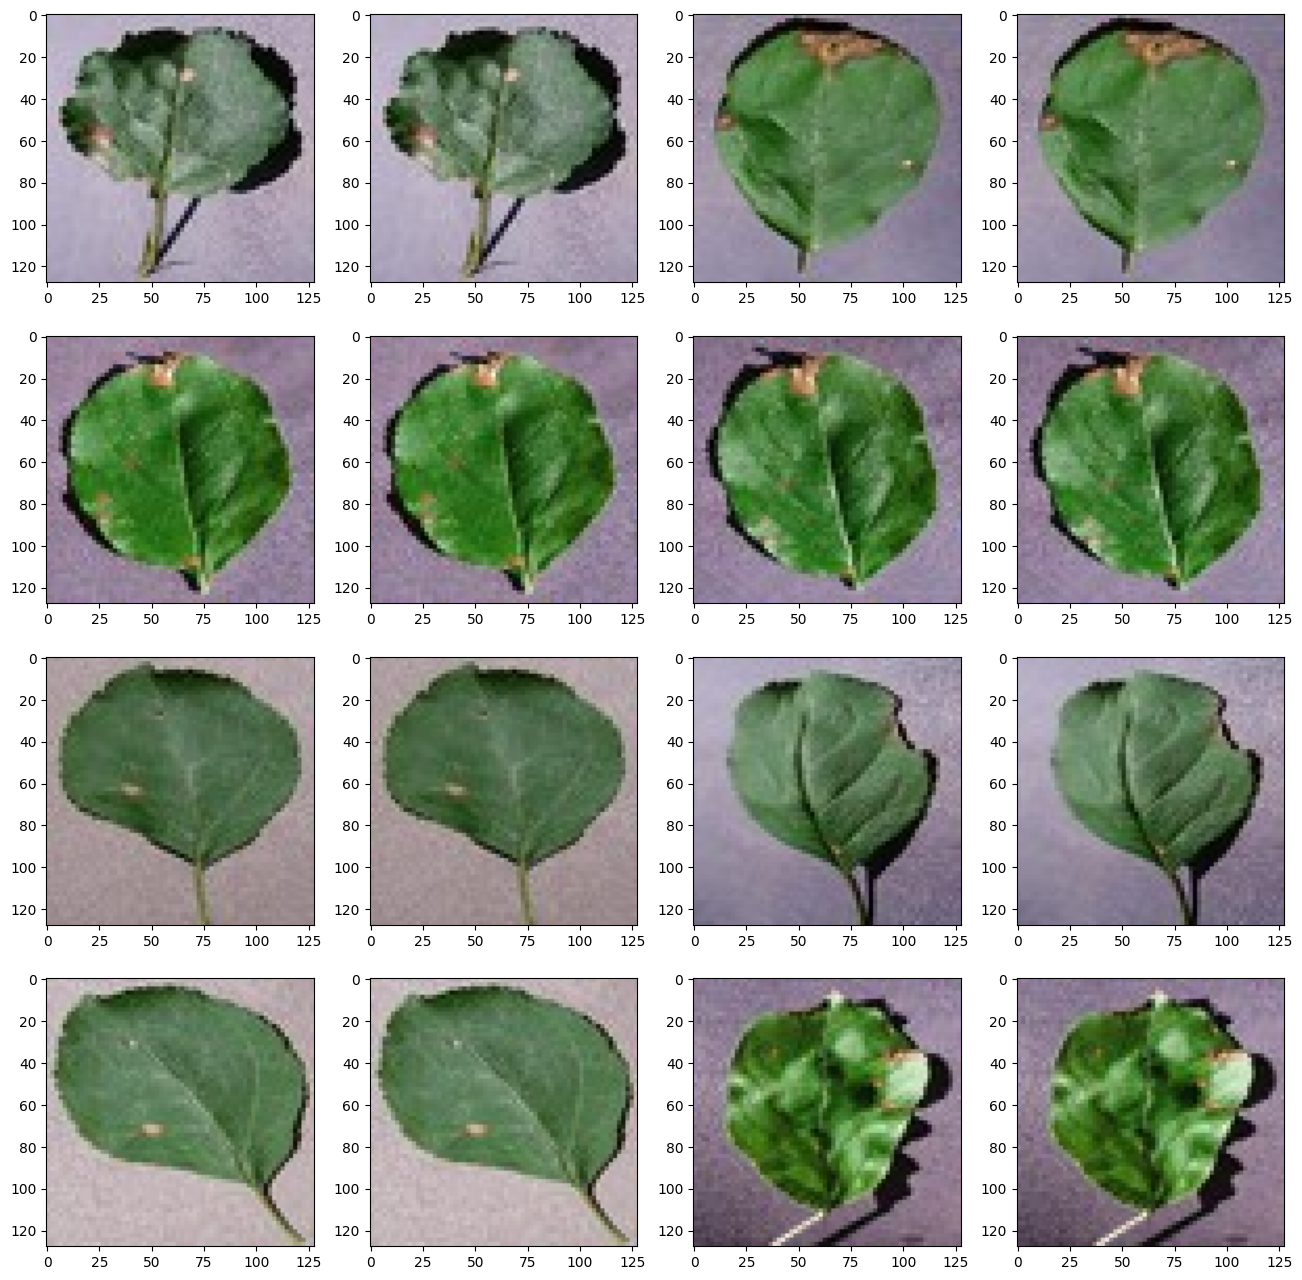

In [34]:
plt.figure(figsize=(16, 16))
for i in range(1, 17):
  plt.subplot(4, 4, i)
  img, label = next(test_generator)
  # print(img.shape)
  # print(label)
  plt.imshow(img[0])
plt.show()

In [35]:
img, label = next(test_generator)
img[0].shape

(128, 128, 3)

#**What is ImageNet?**
ImageNet is formally a project aimed at (manually) labeling and categorizing images into almost 22,000 separate object categories for the purpose of computer vision research.

However, when we hear the term “ImageNet” in the context of deep learning and Convolutional Neural Networks, we are likely referring to the ImageNet Large Scale Visual Recognition Challenge, or ILSVRC for short.

The goal of this image classification challenge is to train a model that can correctly classify an input image into 1,000 separate object categories.

Models are trained on ~1.2 million training images with another 50,000 images for validation and 100,000 images for testing.

# **Exploring Keras Applications for Transfer Learning**

## **VGG16**

In [36]:
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape= (128, 128, 3)) # Include_top = False means excluding the model fully connected layers
base_model.trainable = False ## Not trainable weights

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# **Adding top layers according to number of classes in our data**

In [37]:
flatten_layer = layers.GlobalAveragePooling2D()
# dense_layer_1 = layers.Dense(63, activation='relu')
# dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    prediction_layer
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# **Training**

In [38]:
# sgd = SGD(lr=0.001,decay=1e-6, momentum=0.9, nesterov=True)
# We are going to use accuracy metrics and cross entropy loss as performance parameters
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = model.fit(train_generator,
      steps_per_epoch=int(train_generator.samples/train_generator.batch_size),
      epochs=30,
      validation_data=validation_generator,
      validation_steps=int(validation_generator.samples/validation_generator.batch_size),
      verbose=1)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - acc: 0.4478 - loss: 1.2326 - val_acc: 0.8063 - val_loss: 0.7685
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - acc: 0.7807 - loss: 0.7253 - val_acc: 0.8504 - val_loss: 0.5541
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - acc: 0.8539 - loss: 0.5390 - val_acc: 0.8913 - val_loss: 0.4441
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - acc: 0.8799 - loss: 0.4529 - val_acc: 0.9213 - val_loss: 0.3811
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - acc: 0.9035 - loss: 0.3867 - val_acc: 0.9181 - val_loss: 0.3420
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - acc: 0.9227 - loss: 0.3364 - val_acc: 0.9370 - val_loss: 0.3023
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - acc: 0.9186 - loss: 0.3090 - val_acc: 0.9386 - val_loss: 0.2784
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - acc: 0.9254 - loss: 0.2818 - val_acc: 0.9480 - val_loss: 0.2599
Epoch 9/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 3

# **Saving the model**

In [39]:
model.save("VGG16_plant_deseas.h5")
print("Saved model to disk")

Saved model to disk


# **Loading the model**

In [40]:
model = models.load_model('VGG16_plant_deseas.h5')
print("Model is loaded")

Model is loaded


# **Saving the Weights**

In [44]:
model.save_weights('cnn_classification.weights.h5')

# **Loading the weights**

In [46]:
model.load_weights('cnn_classification.weights.h5')

# **Visualization of training over epoch**

In [47]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

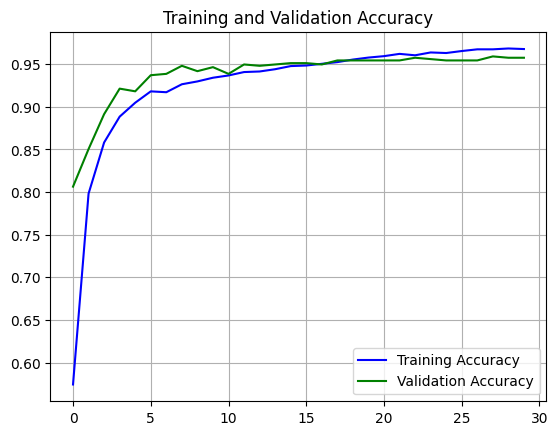

<Figure size 640x480 with 0 Axes>

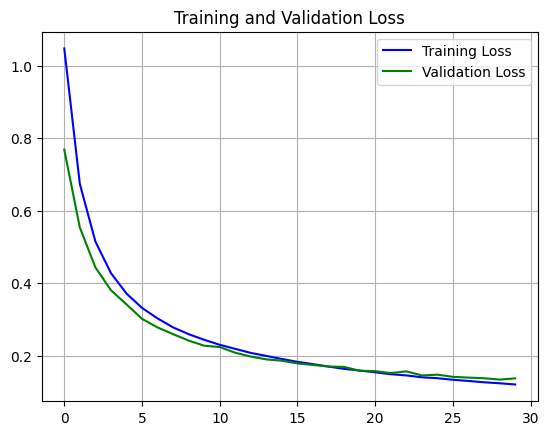

In [48]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

# **Performance measure**

In [51]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(test_generator, steps=int(test_generator.samples/test_generator.batch_size),verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
No of errors = 33/546


In [52]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

93.95604395604396

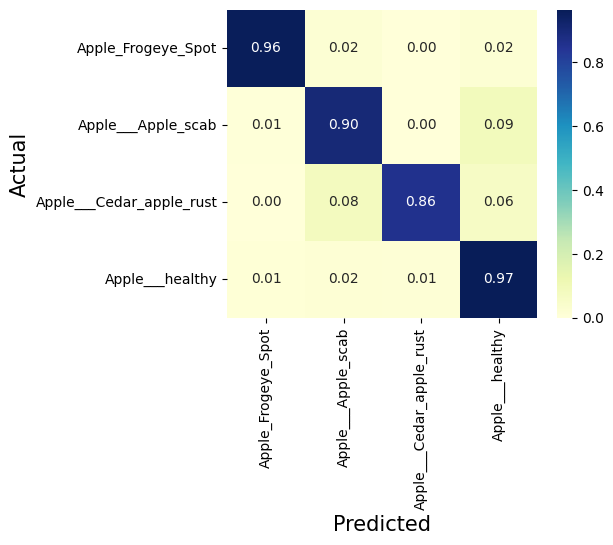

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.97      0.96      0.97       103
      Apple___Apple_scab       0.92      0.90      0.91       134
Apple___Cedar_apple_rust       0.93      0.86      0.89        49
         Apple___healthy       0.94      0.97      0.95       260

                accuracy                           0.94       546
               macro avg       0.94      0.92      0.93       546
            weighted avg       0.94      0.94      0.94       546



# **InceptionNet**

In [55]:
from keras import applications

## Loading InceptionV3 model
base_model = applications.InceptionV3(weights="imagenet", include_top=False, input_shape= (128, 128, 3))
base_model.trainable = False ## Not trainable weights

base_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [56]:
flatten_layer = layers.GlobalAveragePooling2D()
# dense_layer_1 = layers.Dense(63, activation='relu')
# dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    # dense_layer_1,
    # dense_layer_2,
    prediction_layer
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

# Create the EarlyStopping callback with some improvements
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss for more sensitive overfitting detection
    patience=3,                  # Lower patience to stop a bit earlier if no improvement
    restore_best_weights=True,   # Restore the best weights after stopping
    verbose=1                   # Show early stopping events in the output log
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping]  # Pass the early stopping callback here
)



Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - acc: 1.0000 - loss: 0.0012 - val_acc: 0.9244 - val_loss: 0.2552
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - acc: 1.0000 - loss: 0.0011 - val_acc: 0.9244 - val_loss: 0.2676
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - acc: 0.9989 - loss: 0.0054 - val_acc: 0.8756 - val_loss: 0.7377
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - acc: 0.9845 - loss: 0.0463 - val_acc: 0.9197 - val_loss: 0.4099
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [69]:
model.save("InceptionNet_plant_deseas.h5")
print("Saved model to disk")

Saved model to disk


In [70]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

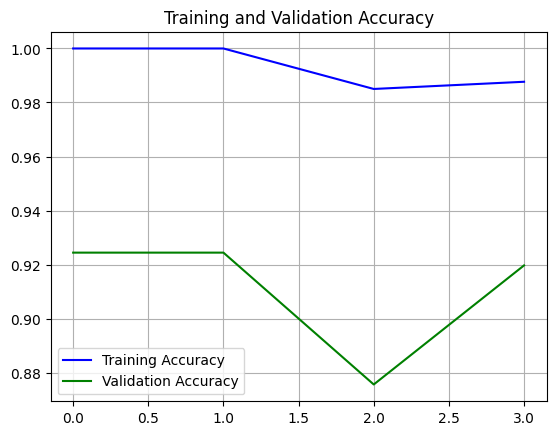

<Figure size 640x480 with 0 Axes>

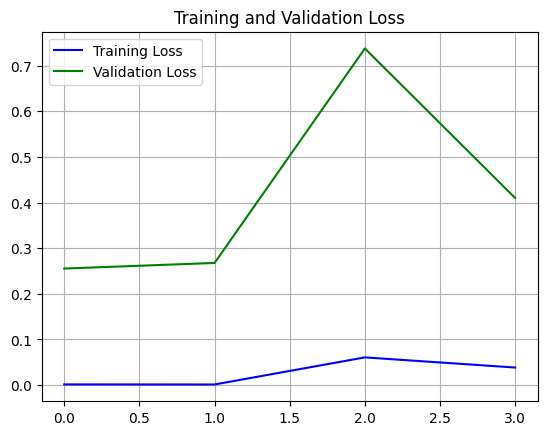

In [71]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [74]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(test_generator, steps=int(test_generator.samples/test_generator.batch_size),verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
No of errors = 44/546


In [75]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

91.94139194139194

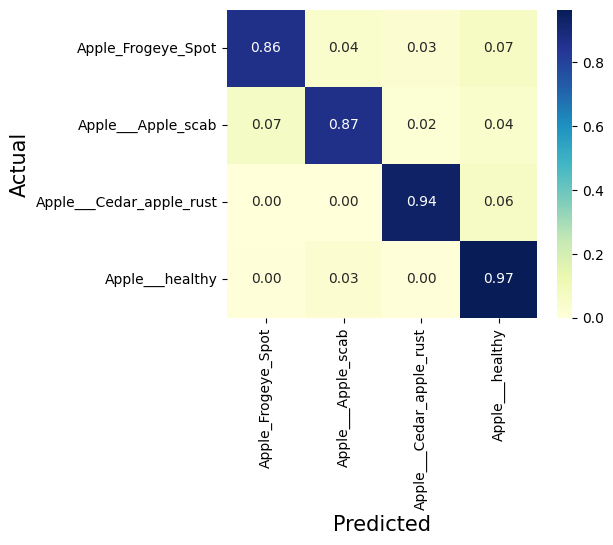

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [78]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.90      0.86      0.88       103
      Apple___Apple_scab       0.91      0.87      0.89       134
Apple___Cedar_apple_rust       0.87      0.94      0.90        49
         Apple___healthy       0.94      0.97      0.95       260

                accuracy                           0.92       546
               macro avg       0.91      0.91      0.91       546
            weighted avg       0.92      0.92      0.92       546



#**ResNet**

In [79]:
from keras import applications

## Loading VGG16 model
base_model = applications.ResNet50(weights="imagenet", include_top=False, input_shape= (128, 128, 3))
base_model.trainable = False ## Not trainable weights

base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [80]:
flatten_layer = layers.GlobalAveragePooling2D()
# dense_layer_1 = layers.Dense(63, activation='relu')
# dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    # dense_layer_1,
    # dense_layer_2,
    prediction_layer
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [84]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = model.fit(train_generator,
      steps_per_epoch=int(train_generator.samples/train_generator.batch_size),
      epochs=30,
      validation_data=validation_generator,
      validation_steps=int(validation_generator.samples/validation_generator.batch_size),
      verbose=1)

Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - acc: 0.5337 - loss: 1.0546 - val_acc: 0.5737 - val_loss: 1.0023
Epoch 2/30
  1/187 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - acc: 0.6250 - loss: 1.0779

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.6250 - loss: 1.0779 - val_acc: 0.5689 - val_loss: 1.0016
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - acc: 0.5387 - loss: 1.0442 - val_acc: 0.5593 - val_loss: 0.9960
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.5000 - loss: 0.9998 - val_acc: 0.5609 - val_loss: 0.9966
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - acc: 0.5443 - loss: 1.0324 - val_acc: 0.5801 - val_loss: 0.9891
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.5000 - loss: 1.1532 - val_acc: 0.5801 - val_loss: 0.9890
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - acc: 0.5425 - loss: 1.0285 - val_acc: 0.5801 - val_loss: 0.9797
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.6250 - loss: 1.0150 - val_acc: 0.5801 - val_loss: 0.9796
Epoch 9/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - acc: 0.5420 - loss: 1.0294 - val_acc: 0.5785 - val_loss: 0.9755
Epoch 10/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.

In [85]:
model.save("ResNet_plant_deseas.h5")
print("Saved model to disk")

Saved model to disk


In [86]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

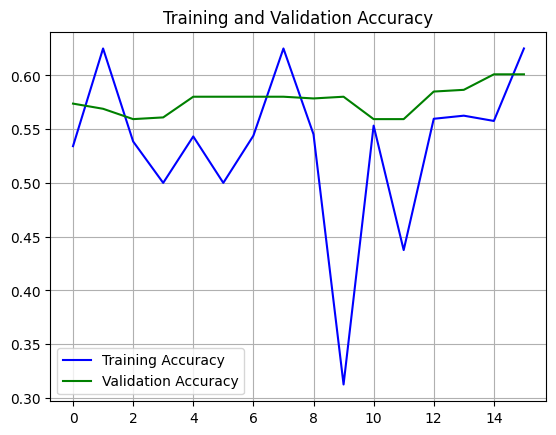

<Figure size 640x480 with 0 Axes>

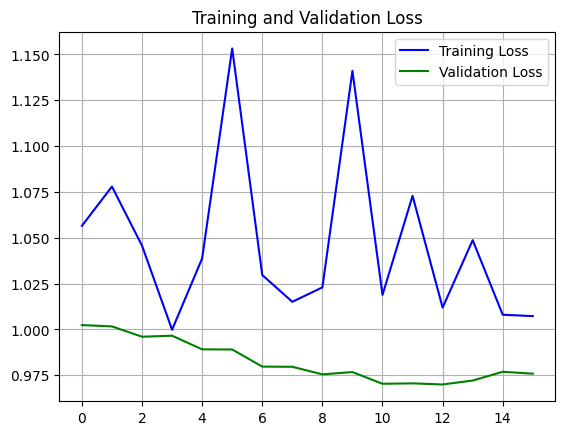

In [87]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [90]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(test_generator, steps=int(test_generator.samples/test_generator.batch_size),verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
No of errors = 254/546


In [91]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

53.47985347985348

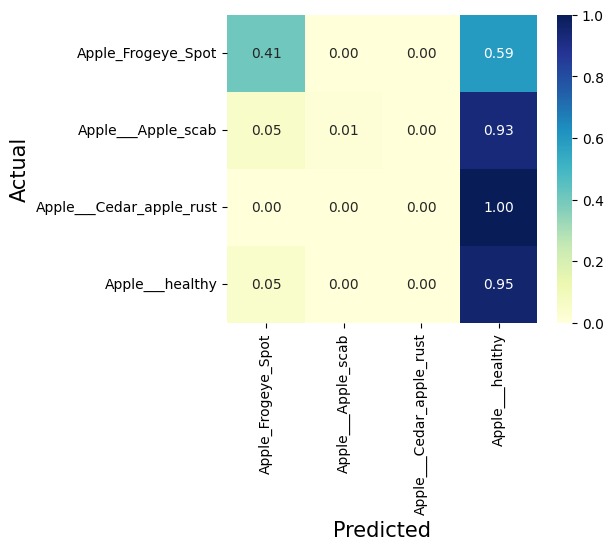

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [95]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.69      0.41      0.51       103
      Apple___Apple_scab       1.00      0.01      0.03       134
Apple___Cedar_apple_rust       0.00      0.00      0.00        49
         Apple___healthy       0.51      0.95      0.67       260

                accuracy                           0.53       546
               macro avg       0.55      0.34      0.30       546
            weighted avg       0.62      0.53      0.42       546



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
